In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import yaml
from icecream import ic

from bandit_sim.common import Action, Reward
from bandit_sim.configs import AlgorithmConfig, BanditEnvConfig
from bandit_sim.setting import Settings

In [25]:
result_dir = "20250817-0139-alignment"
output_dir = os.path.join("../output/", result_dir)

config = {}

with open(os.path.join(output_dir, "simulation_config.yaml"), "r") as config_file:
    raw_dict = yaml.full_load(config_file)  # TODO: Make config loadable.
    for k, v in raw_dict.items():
        if k == "bandit_env_config":
            config_value = BanditEnvConfig.model_validate(v)
        elif k == "algorithm_configs":
            config_value = [AlgorithmConfig.model_validate(alg_dict) for alg_dict in v]
        elif k == "settings":
            config_value = Settings(**v)
        else:
            config_value = v

        config[k] = config_value

settings: Settings = config["settings"]
algorithms: list[AlgorithmConfig] = config["algorithm_configs"]
bandit_env_config = config["bandit_env_config"]
bandit_env_name = config["bandit_env_name"]

# config
T = settings.T
trials = settings.num_trials
K = settings.num_arms
base_seed = settings.base_seed

num_trials = settings.num_trials
trial_id_overrides = settings.trial_id_overrides

if trial_id_overrides is not None and len(trial_id_overrides) > 0:
    trial_ids = trial_id_overrides
    num_trials = len(trial_ids)
else:
    trial_ids = range(num_trials)

num_algs = len(algorithms)
K = 32
K_env = K // 2

all_regrets = np.zeros((num_trials, num_algs, T), dtype=Reward)
all_actions = np.zeros((num_trials, num_algs, T), dtype=Action)


def generate_base_filename(base_seed: int, trial_id: int, alg_label: str) -> str:
    return f"{alg_label}_seed{base_seed}_id{trial_id}.npy"


for i, trial_id in enumerate(trial_ids):
    for alg in algorithms:
        filename = generate_base_filename(base_seed, trial_id, alg.label)
        with open(os.path.join(output_dir, f"regrets_{filename}"), "rb") as f:
            all_regrets[i] = np.load(f)
        with open(os.path.join(output_dir, f"actions_{filename}"), "rb") as f:
            all_actions[i] = np.load(f)

In [26]:
regret_means = np.mean(all_regrets, axis=0)
regret_stds = np.std(all_regrets, axis=0)

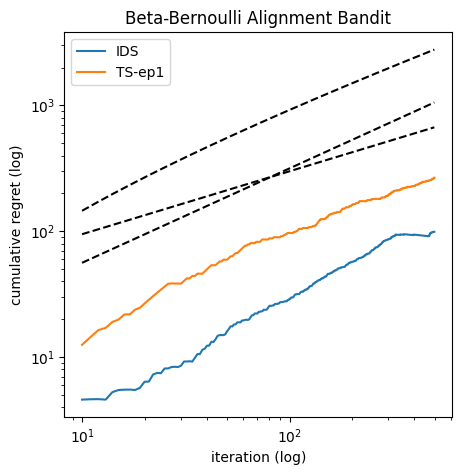

In [28]:
"""
Section below is for plotting
"""
title = bandit_env_name
output = bandit_env_config.label

# plt.figure(figsize=(5, 5))
# for i in range(num_trials):
#     for alg in range(num_algs):
#         plt.plot(regrets[i][alg], color="blue", alpha=0.3)

# for alg in range(num_algs):
#     plt.plot(regret_means[alg], label=algorithms[alg].label, color="blue")
# # plt.xlim(left=0, right=T)
# plt.title(title)
# plt.xlabel("timestep t")
# plt.ylabel("cumulative regret")
# plt.legend()
# plt.savefig(f"images/{output}.png")
# plt.show()

# log log plot
plt.figure(figsize=(5, 5))
for alg in range(num_algs):
    plt.plot(
        np.arange(10, T),
        regret_means[alg][10:],
        label=algorithms[alg].label,
    )
    plt.fill_between(
        np.arange(10, T),
        regret_means[alg][10:] + regret_stds[alg][10:],
        regret_means[alg][10:] - regret_stds[alg][10:],
        alpha=0.3,
    )
# lines for comparison
x = np.arange(10, T)
sqrt_x = 30 * np.sqrt(x)
sqrt_x_log_x = 20 * np.sqrt(x) * np.log(x)
x_3_4 = 10 * x ** (3 / 4)

# plt.plot(x, x, "k--")
plt.plot(x, sqrt_x, "k--")
plt.plot(x, sqrt_x_log_x, "k--")
plt.plot(x, x_3_4, "k--")
# plt.xlim(left=0, right=T)
# plt.ylim(bottom=0, top=120)
plt.title(title)
plt.xlabel("iteration (log)")
plt.ylabel("cumulative regret (log)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [ ]:
env_actions = (all_actions < 16).astype(int)
human_actions = 1 - env_actions

cum_env_actions = np.cumsum(env_actions, axis=1)
cum_human_actions = np.cumsum(human_actions, axis=1)

/var/folders/b4/p5yky4js5cs379v1t5vsgv8m0000gn/T/ipykernel_81134/1243628275.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


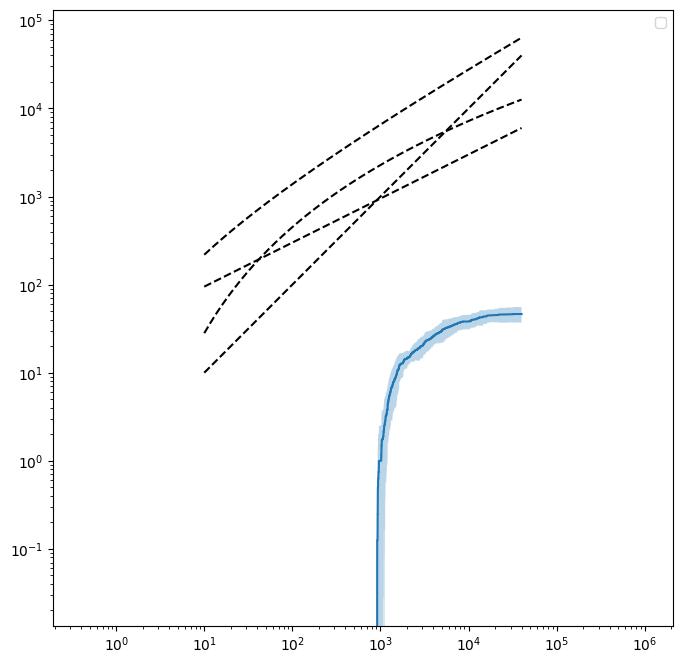

In [24]:
plt.figure(figsize=(8, 8))
for i in range(len(all_actions)):
    # plt.plot(np.arange(T), cum_human_actions[i], color="red", alpha=0.3)
    # plt.plot(np.arange(T), cum_human_actions[i], label=i, alpha=0.8)
    ...

plt.plot(np.arange(10, T, 1), np.mean(cum_human_actions, axis=0)[10:])
plt.fill_between(
    np.arange(10, T, 1),
    np.mean(cum_human_actions, axis=0)[10:] + np.std(cum_human_actions, axis=0)[10:],
    np.mean(cum_human_actions, axis=0)[10:] - np.std(cum_human_actions, axis=0)[10:],
    alpha=0.3,
)

sqrt_t = np.sqrt(np.arange(10, T, 1))
sqrt_t_log_t = np.sqrt(np.arange(10, T, 1)) * np.log(np.arange(10, T, 1))
log_t = np.log(np.arange(10, T, 1)) * np.log(np.arange(10, T, 1))

plt.plot(np.arange(10, T, 1), np.arange(10, T, 1), color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), 30 * sqrt_t_log_t, color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), log_t**2, color="black", linestyle="--")
plt.plot(np.arange(10, T, 1), 30 * sqrt_t, color="black", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.legend()
plt.show()

In [25]:
actions = actions_IDS[2]

In [26]:
unique, counts = np.unique(actions, return_counts=True)

for i in range(16):
    ic(f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}")

n_h = sum(counts[16:])
n_env = sum(counts[:16])
ic(n_h)
ic(f"proportion: {n_h / (n_h + n_env)}")

ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '0: 729		 0h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '1: 81		 1h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '2: 524		 2h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '3: 83		 3h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '4: 162		 4h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '5: 239		 5h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '6: 36749		 6h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '7: 175		 7h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '8: 75		 8h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '9: 173		 9h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '10: 203		 10h: 3'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '11: 65		 11h: 2'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '12: 166		 12h: 2'
ic| f"{i}: {counts[i]}\t\t {i}h: {counts[i + 16]}": '13: 92		 13h: 2'
ic| f"{i}: {counts[i]}\t\t {i

'proportion: 0.001125'

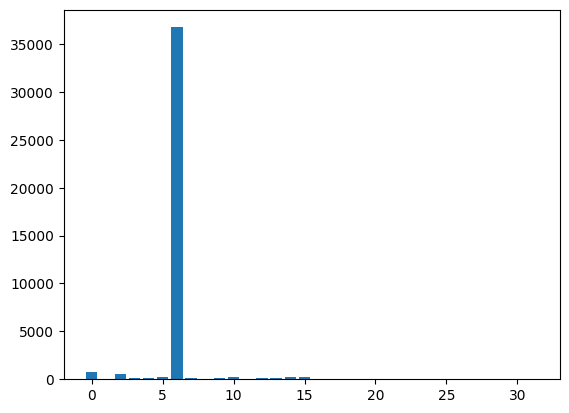

In [27]:
plt.bar(unique, counts)
plt.show()